In [86]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
import time
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [88]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

# Set up Chrome options
options = Options()
options.add_experimental_option("detach", True)
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

# Initialize Chrome WebDriver with ChromeDriverManager
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Navigate to SoFi Yahoo Finance page
driver.get("https://finance.yahoo.com/quote/SOFI/history")


In [89]:
try:
    # Locate the fin-streamer element with the class "livePrice yf-1tejb6"
    live_price_element = driver.find_element(By.CLASS_NAME, "livePrice")
    
    # Retrieve the text inside the <span> tag, which contains the current price
    live_price = live_price_element.find_element(By.TAG_NAME, "span").text
    print("Live Price:", live_price)
except Exception as e:
    print("Error locating live price element:", e)


Live Price: 11.04


In [91]:


# Step 1: Open the Date Range dropdown
try:
    date_range_button = WebDriverWait(driver, 20).until(
        EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'tertiary-btn') and contains(@class, 'menuBtn')]"))
    )
    print("Date Range button found, clicking...")
    date_range_button.click()
    time.sleep(2)
except Exception as e:
    print("Error opening date range dropdown:", e)

# Step 2: Select "Max" date range using the button with value="MAX",other than max if you want any other data change the below @value .
try:
    max_option = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//button[@value='MAX']"))
    )
    print("Max date range option found, clicking...")
    max_option.click()
    time.sleep(2)
except Exception as e:
    print("Error selecting Max date range:", e)




Date Range button found, clicking...
Max date range option found, clicking...


In [ ]:
# If the custom date is provided then the done button need to be clicked or else no need
# Step 3: Apply the date range by clicking "Done" using JavaScript if needed
# done_button = WebDriverWait(driver, 10).until(
# EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'primary-btn') and contains(@class, 'rounded') and contains(@class, 'yf-15mk0m')]"))
# )
# driver.execute_script("arguments[0].click();", done_button)
# time.sleep(5)  # Wait for the table to load

In [92]:
# Step 3: Wait for the historical data table to load and scrape data
try:
    # Wait for the table to load completely
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, "//table[contains(@class, 'table yf-h2urb6')]//tbody/tr"))
    )
    print("Table found, scraping data...")

    # Find the table rows containing the historical data
    rows = driver.find_elements(By.XPATH, "//table[contains(@class, 'table yf-h2urb6')]//tbody/tr")

    # Extract data into a list
    historical_data = []
    for row in rows:
        # Each cell contains data like Date, Open, High, Low, Close, Adj Close, Volume
        cols = row.find_elements(By.TAG_NAME, "td")
        if len(cols) == 7:  # Proceed if row has complete data
            date = cols[0].text
            open_price = cols[1].text
            high = cols[2].text
            low = cols[3].text
            close = cols[4].text
            adj_close = cols[5].text
            volume = cols[6].text
            historical_data.append([date, open_price, high, low, close, adj_close, volume])

    # Convert the data to a DataFrame for easier manipulation
    df = pd.DataFrame(historical_data, columns=["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"])

    # Preview the DataFrame
    print(df.head())
except Exception as e:
    print("Error scraping historical data:", e)

Table found, scraping data...
           Date   Open   High    Low  Close Adj Close       Volume
0   Nov 1, 2024  11.21  11.22  10.81  11.04     11.04   41,561,500
1  Oct 31, 2024  11.16  11.32  10.88  11.17     11.17   59,129,200
2  Oct 30, 2024  10.47  11.50  10.46  11.22     11.22   95,149,900
3  Oct 29, 2024  10.75  10.80   9.77  10.47     10.47  164,917,900
4  Oct 28, 2024  11.21  11.31  11.02  11.19     11.19   69,753,400


In [117]:
df.to_csv("sofi_historical_data.csv", index=False)

After the Web scraping , Preprocess a dataset,perform feature engineering and then build and train a model.

In [118]:
data=pd.read_csv("sofi_historical_data.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Nov 1, 2024",11.21,11.22,10.81,11.04,11.04,"41,561,500"
1,"Oct 31, 2024",11.16,11.32,10.88,11.17,11.17,"59,129,200"
2,"Oct 30, 2024",10.47,11.50,10.46,11.22,11.22,"95,149,900"
3,"Oct 29, 2024",10.75,10.80,9.77,10.47,10.47,"164,917,900"
4,"Oct 28, 2024",11.21,11.31,11.02,11.19,11.19,"69,753,400"


In [119]:
# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].str.replace(',', '').astype(float)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-11-01,11.21,11.22,10.81,11.04,11.04,41561500.0
2024-10-31,11.16,11.32,10.88,11.17,11.17,59129200.0
2024-10-30,10.47,11.50,10.46,11.22,11.22,95149900.0
2024-10-29,10.75,10.80,9.77,10.47,10.47,164917900.0
2024-10-28,11.21,11.31,11.02,11.19,11.19,69753400.0


In [120]:
# Feature Engineering
data['5_day_avg']=data['Close'].rolling(window=5).mean()
data['10_day_avg']=data['Close'].rolling(window=10).mean()
data['lag_1']=data['Close'].shift(1)
# data= data.fillna(data.mean())
data.dropna(inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,5_day_avg,10_day_avg,lag_1
Date,,,,,,,,,
2024-10-21,10.26,10.54,10.19,10.40,10.40,50814300.0,10.664,10.841,10.58
2024-10-18,9.91,10.18,9.88,10.18,10.18,31400300.0,10.502,10.755,10.40
2024-10-17,10.01,10.03,9.62,9.87,9.87,50293900.0,10.290,10.625,10.18
2024-10-16,10.23,10.32,9.91,10.04,10.04,48045000.0,10.214,10.507,9.87
2024-10-15,10.16,10.49,10.03,10.18,10.18,87195400.0,10.134,10.478,10.04


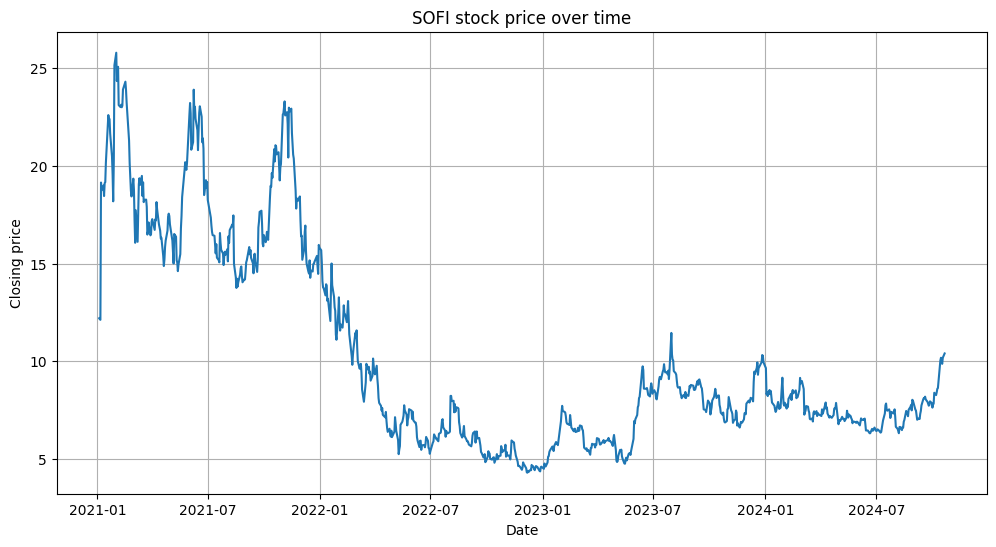

In [121]:
plt.figure(figsize=(12,6))
plt.plot(data.index,data['Close'],label="Closing price")
plt.title("SOFI stock price over time")
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.grid(True)
# plt.legend()
plt.show()

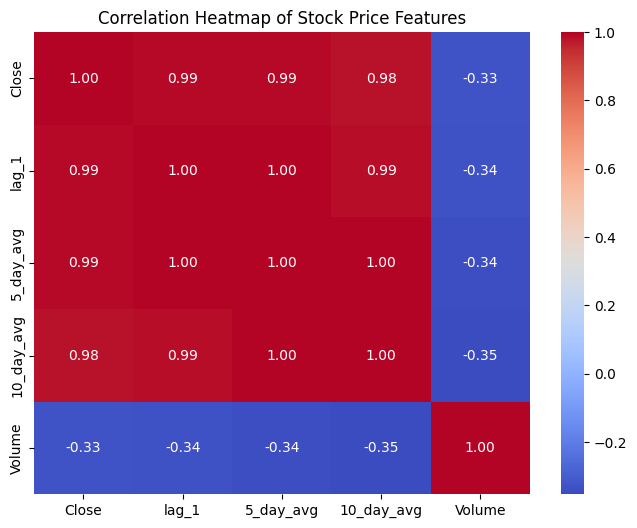

In [122]:
import seaborn as sns

# Select relevant features for the heatmap
features = data[['Close', 'lag_1', '5_day_avg', '10_day_avg', 'Volume']]

# Calculate the correlation matrix
correlation_matrix = features.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Stock Price Features")
plt.show()


Key Observations from the Heatmap

High Correlation Between Close, lag_1, 5_day_avg, and 10_day_avg:

The Close price is highly correlated (correlation close to 1) with lag_1, 5_day_avg, and 10_day_avg. This suggests that recent prices (previous day's close and moving averages) are strong predictors of the current closing price.
This is expected in time series data, where recent values often carry predictive information for the near future. Including these features in the model makes sense as they capture the trend in stock prices.
Multicollinearity Between lag_1, 5_day_avg, and 10_day_avg:

lag_1, 5_day_avg, and 10_day_avg are all almost perfectly correlated with each other.

Multicollinearity means that these features contain redundant information, which could cause issues in models that are sensitive to correlated features (like linear regression).
However, models like Gradient Boosting and LSTM are generally less affected by multicollinearity, so you can include all these features without major issues.

Weak Correlation Between Volume and Price-Related Features:

Volume has a low negative correlation (around -0.3 to -0.4) with Close and the moving averages.
This indicates that trading volume does not have a strong linear relationship with the stock price in this dataset. However, volume might still provide some predictive value, especially in periods of high or low trading activity, so it’s worth experimenting with.


In [123]:
# Define features and target
x = data[['lag_1', '5_day_avg', '10_day_avg']]
y = data['Close']

In [124]:
# Scaling Features for LSTM
scaler=MinMaxScaler()
x_scaled=scaler.fit_transform(x)
y_scaled=scaler.fit_transform(y.values.reshape(-1,1))


In [125]:
# Reshape X for LSTM model (samples, timesteps, features)
X_scaled = x_scaled.reshape((x_scaled.shape[0], 1, x_scaled.shape[1]))

In [126]:
# Step 1: Reshape X to the 3D format for LSTM
X_reshaped = x.values.reshape((x.shape[0], 1, x.shape[1]))

# Step 2: Split into training and test sets
train_size = int(len(X_reshaped) * 0.8)
x_train, x_test = X_reshaped[:train_size], X_reshaped[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Now x_train should have the shape (samples, timesteps, features)
print("x_train shape:", x_train.shape)  


x_train shape: (764, 1, 3)


In [127]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_test, y_test), verbose=0)

/Users/abhishekpawar/Documents/Alpa data/safari_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [128]:
# Predict on the training set for visualization
y_train_pred_scaled = lstm_model.predict(x_train)
y_train_pred = scaler.inverse_transform(np.concatenate([y_train_pred_scaled, x_train[:, 0, 1:]], axis=1))[:, 0]

# Ensure y_train is a NumPy array before reshaping
y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train  # Convert to array if it's a Series
y_train_original = scaler.inverse_transform(y_train_array.reshape(-1, 1))[:, 0]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [129]:
# Ensure y_test is a NumPy array before reshaping
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test  # Convert to array if it's a Series
y_test_original = scaler.inverse_transform(y_test_array.reshape(-1, 1))[:, 0]

# Ensure that `scaler` is used correctly for inverse transformation of predictions
y_test_pred_scaled=lstm_model.predict(x_test)
y_test_pred = scaler.inverse_transform(np.concatenate([y_test_pred_scaled, x_test[:, 0, 1:]], axis=1))[:, 0]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step


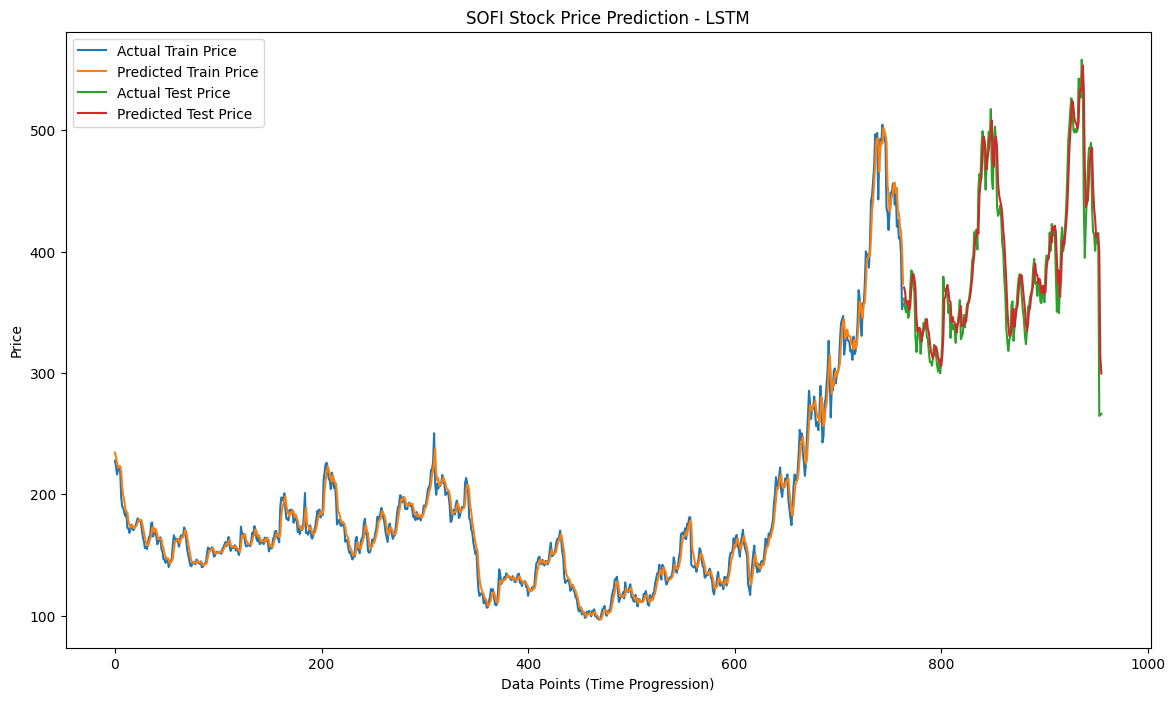

In [130]:
# Plot actual vs predicted prices for both training and testing data
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(range(len(y_train_original)), y_train_original, label="Actual Train Price")
plt.plot(range(len(y_train_original)), y_train_pred, label="Predicted Train Price")

# Plot testing data
plt.plot(range(len(y_train_original), len(y_train_original) + len(y_test_original)), y_test_original, label="Actual Test Price")
plt.plot(range(len(y_train_original), len(y_train_original) + len(y_test_original)), y_test_pred, label="Predicted Test Price")

plt.title("SOFI Stock Price Prediction - LSTM")
plt.xlabel("Data Points (Time Progression)")
plt.ylabel("Price")
plt.legend()
plt.show()

In [132]:
# Compute accuracy metrics
# Training Metrics
train_mae = mean_absolute_error(y_train_original, y_train_pred)
train_mse = mean_squared_error(y_train_original, y_train_pred)
train_rmse = np.sqrt(train_mse)

# Testing Metrics
test_mae = mean_absolute_error(y_test_original, y_test_pred)
test_mse = mean_squared_error(y_test_original, y_test_pred)
test_rmse = np.sqrt(test_mse)

# Print accuracy metrics
print("Training Metrics:")
print(f"MAE: {train_mae}")
print(f"RMSE: {train_rmse}")

print("\nTesting Metrics:")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")

Training Metrics:
MAE: 6.1257673549751965
RMSE: 8.861970133523958

Testing Metrics:
MAE: 14.607326332545282
RMSE: 21.711777930216122


In [114]:
data.head(1)

,Open,High,Low,Close,Adj Close,Volume,5_day_avg,10_day_avg,lag_1
Date,,,,,,,,,
2024-10-21,10.26,10.54,10.19,10.4,10.4,50814300.0,10.664,10.841,10.58


In [113]:
# Retrieve the latest closing price in the dataset (today's price)
today_price = data['Close'].iloc[-1]
print(f"Today's closing price: {today_price}")


Today's closing price: 12.2


The Complete code for the prediction of the closing price with LSTM

/Users/abhishekpawar/Documents/Alpa data/safari_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/Users/abhishekpawar/Documents/Alpa data/safari_env/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Predicted closing price for today: 13.98654842376709


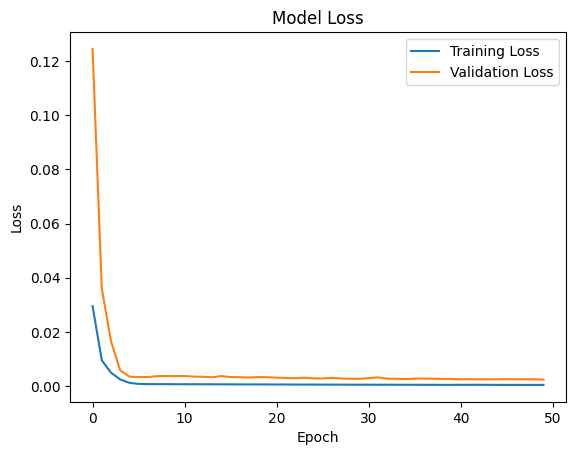

In [ ]:
# Load and preprocess data (assuming 'data' is already loaded and feature-engineered)
data=pd.read_csv("sofi_historical_data.csv")

# Feature engineering
data['5_day_avg'] = data['Close'].rolling(window=5).mean()
data['10_day_avg'] = data['Close'].rolling(window=10).mean()
data['lag_1'] = data['Close'].shift(1)
data.dropna(inplace=True)  # Dropping initial rows with NaNs in engineered features

# Separating features and target
X = data[['lag_1', '5_day_avg', '10_day_avg']]
y = data['Close']

# Scaling
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

# Reshape X for LSTM (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Define and train the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# Predict on the latest row (most recent data point) for today's prediction
latest_data = X.iloc[-1].values.reshape(1, -1)  # Latest row of features

# Scale and reshape the latest data
latest_data_scaled = feature_scaler.transform(latest_data).reshape((1, 1, X.shape[1]))

# Make the prediction
predicted_close_scaled = lstm_model.predict(latest_data_scaled)
predicted_close = target_scaler.inverse_transform(predicted_close_scaled)[0][0]

print(f"Predicted closing price for today: {predicted_close}")

# Optional: Visualize the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


The below code extracted from the previous project. The features and model training is extracted.

Epoch 1/50


/Users/abhishekpawar/Documents/Alpa data/safari_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0521 - val_loss: 0.1275
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.0109 - val_loss: 0.0222
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.0034 - val_loss: 0.0052
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 0.0010 - val_loss: 0.0034
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 6.7725e-04 - val_loss: 0.0035
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 6.2458e-04 - val_loss: 0.0036
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2314e-04 - val_loss: 0.0034
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2034e-04 - val_loss: 0.0034
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 5.5055e-04 - val_loss: 0.0033
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 4.5282e-04 - val_loss: 0.0033
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 5.2062e-04 - val_loss: 0.0033
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

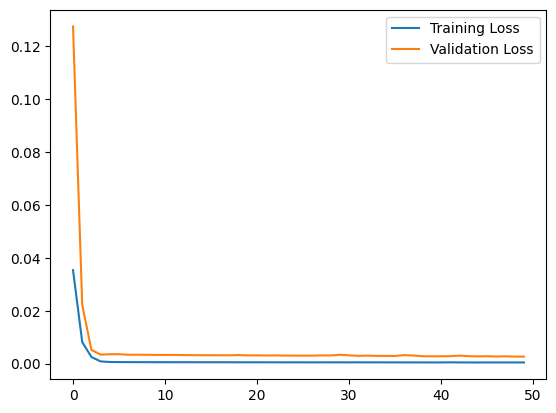

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted closing price for today: 13.814421546459197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted closing price for tomorrow: 13.470322829484939


/Users/abhishekpawar/Documents/Alpa data/safari_env/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/abhishekpawar/Documents/Alpa data/safari_env/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [84]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Step 1: Load Data
data = pd.read_csv("sofi_historical_data.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].str.replace(',', '').astype(float)

# Step 2: Feature Engineering
data['5_day_avg'] = data['Close'].rolling(window=5).mean()
data['10_day_avg'] = data['Close'].rolling(window=10).mean()
data['lag_1'] = data['Close'].shift(1)
data['lag_2'] = data['Close'].shift(2)
data.dropna(inplace=True)

# Step 3: Define Features and Target
features = data[['lag_1', 'lag_2', '5_day_avg', '10_day_avg']]
target = data['Close']

# Step 4: Data Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)
y_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

# Reshape Data for LSTM (samples, timesteps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split Data into Train and Test Sets
train_size = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:train_size], X_reshaped[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Build and Train the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Plot Loss for Training and Validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Step 8: Predict Today’s Closing Price
latest_data = features.iloc[-1].values.reshape(1, -1)  # Get the last row of features

# Use scaler fitted with the correct features
scaler_features = MinMaxScaler().fit(features)
latest_data_scaled = scaler_features.transform(latest_data).reshape((1, 1, latest_data.shape[1]))

predicted_today_scaled = model.predict(latest_data_scaled)
predicted_today = scaler.inverse_transform([[predicted_today_scaled[0][0]] + list(latest_data[0][1:])])[0][0]

print(f"Predicted closing price for today: {predicted_today}")

# Step 9: Predict Tomorrow’s Closing Price
# Shift data for tomorrow's prediction by replacing the last 'lag' with today's predicted closing price
tomorrow_data = np.append(predicted_today, latest_data[0][:-1]).reshape(1, -1)
tomorrow_data_scaled = scaler_features.transform(tomorrow_data).reshape((1, 1, tomorrow_data.shape[1]))

predicted_tomorrow_scaled = model.predict(tomorrow_data_scaled)
predicted_tomorrow = scaler.inverse_transform([[predicted_tomorrow_scaled[0][0]] + list(latest_data[0][1:])])[0][0]

print(f"Predicted closing price for tomorrow: {predicted_tomorrow}")


The plot shows the training and validation loss over 50 epochs for your LSTM model. Here’s what the plot indicates:

Loss Decrease:

Both the training and validation losses decrease rapidly in the initial epochs. This is a positive sign, as it indicates that the model is learning and improving by minimizing the error on both the training and validation data.

Convergence:

Around epoch 10, both the training and validation losses stabilize and approach close to zero, indicating that the model has likely converged. This means further training doesn’t lead to significant improvements in the loss.

Low Validation Loss:

The validation loss is very close to the training loss, which implies that the model generalizes well to unseen data (from the validation set) and is not overfitting.

Overall Interpretation:

The low and stable losses for both training and validation suggest that the model is well-trained and is capable of capturing the underlying patterns in the data without overfitting.
This should result in reasonable predictions, although real-world stock market data can be highly unpredictable due to external factors that may not be present in historical data.

In summary, this plot indicates that your LSTM model has trained effectively and seems to generalize well, at least based on the data you provided for validation. This is a good indicator for future predictions, but it’s always a good idea to monitor the model’s performance on new data as well.